In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import numpy as np
from IPython.display import Image

### Using 2007 since this year had a high default rate. The following files were produced using the LPPUB_StatFile_Production Notebook

In [2]:
processed_file_nameQ1 = '2007Q1_BaseTable7'
processed_file_nameQ2 = '2007Q2_BaseTable7'
processed_file_nameQ3 = '2007Q3_BaseTable7'
processed_file_nameQ4 = '2007Q4_BaseTable7'

In [3]:
df_fnma_dataQ1 = pd.read_csv(processed_file_nameQ1, dtype={'zip_3':'object'})
df_fnma_dataQ2 = pd.read_csv(processed_file_nameQ2, dtype={'zip_3':'object'})
df_fnma_dataQ3 = pd.read_csv(processed_file_nameQ3, dtype={'zip_3':'object'})
df_fnma_dataQ4 = pd.read_csv(processed_file_nameQ4, dtype={'zip_3':'object'})


In [4]:
df_fnma_data= pd.concat([df_fnma_dataQ1,df_fnma_dataQ2,df_fnma_dataQ3,df_fnma_dataQ4], ignore_index= True)

In [5]:
def generate_plot_data(input_df, filter_col, list_input_cols, groupby_column, agg_method, list_output_cols):
    df = input_df.loc[input_df[filter_col].isna()==False, [groupby_column]+list_input_cols]
    df = df.groupby(groupby_column)[list_input_cols].agg(agg_method).reset_index().\
    rename(columns = dict(zip(list_input_cols,list_output_cols)))
    
    return df


df_defaults= generate_plot_data(df_fnma_data, 'FCC_DTE', ['LOAN_ID'],'state','count',['TotalForeclosed'])
df_total_loans = generate_plot_data(df_fnma_data, 'LOAN_ID', ['LOAN_ID'],'state','count',['TotalLoans'])

df_data_plot = df_total_loans.merge(df_defaults, on='state', how= 'left')
df_data_plot['TotalForeclosed']=(df_data_plot['TotalForeclosed'].fillna(0))
df_data_plot['ForeclosedPctage'] = round(df_data_plot['TotalForeclosed']/df_data_plot['TotalLoans']*100,2)


## Number of Foreclosures By State

During 2007, it was primarily California, Arizona, Nevada and Florida which had the highest number of foreclosures.

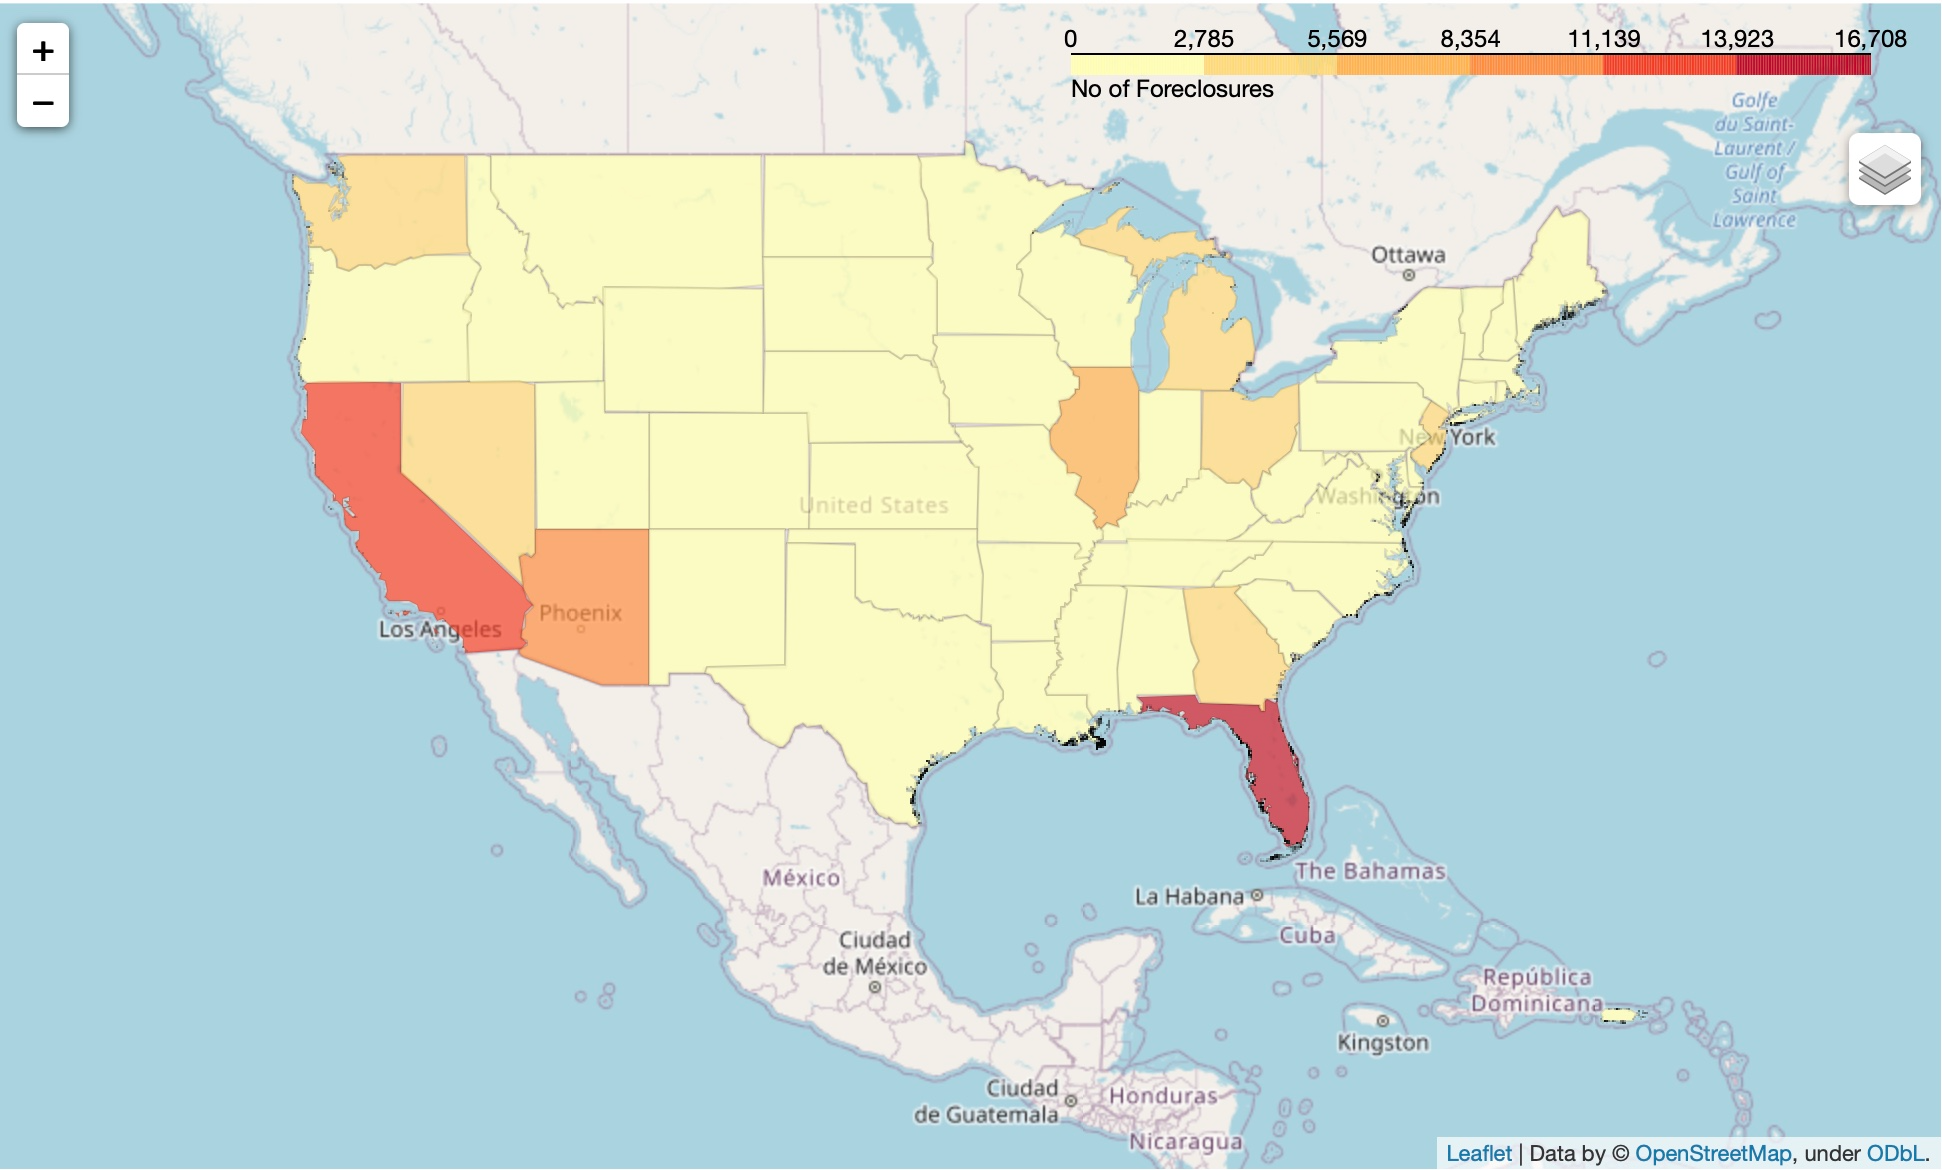

In [6]:
## Uncomment Code Below to generate the Folium Maps to display Foreclosures by State. I generated the Maps 
## and saved a PNG file of the Chart and is displaed Below

#zip_3_geodata = geopandas.read_file("http://faculty.baruch.cuny.edu/geoportal/data/esri/usa/census/zip3.zip")
#state_geodata = geopandas.read_file("http://faculty.baruch.cuny.edu/geoportal/data/esri/usa/census/dtl_st.zip")


#fannie_foreclosed_map = folium.Map(location=[35, -95],zoom_start=4.25)
#folium.Choropleth(
#    geo_data=state_geodata,
#    name="choropleth",
#    data=df_data_plot,
#    columns=["state", "TotalForeclosed"],
#     key_on="feature.properties.STATE_ABBR",
#  
#    fill_color="YlOrRd",
#    fill_opacity=0.7,
#    line_opacity=.1,
#    legend_name=" No of Foreclosures",
#).add_to(fannie_foreclosed_map)

#folium.LayerControl().add_to(fannie_foreclosed_map)

Image(filename='CountOfForeclosures.png')

## Percentage of Foreclosures By State

However, it was Nevada, Arizona and Florida which led the pack in foreclosures as a percentage of loans issued in that state.

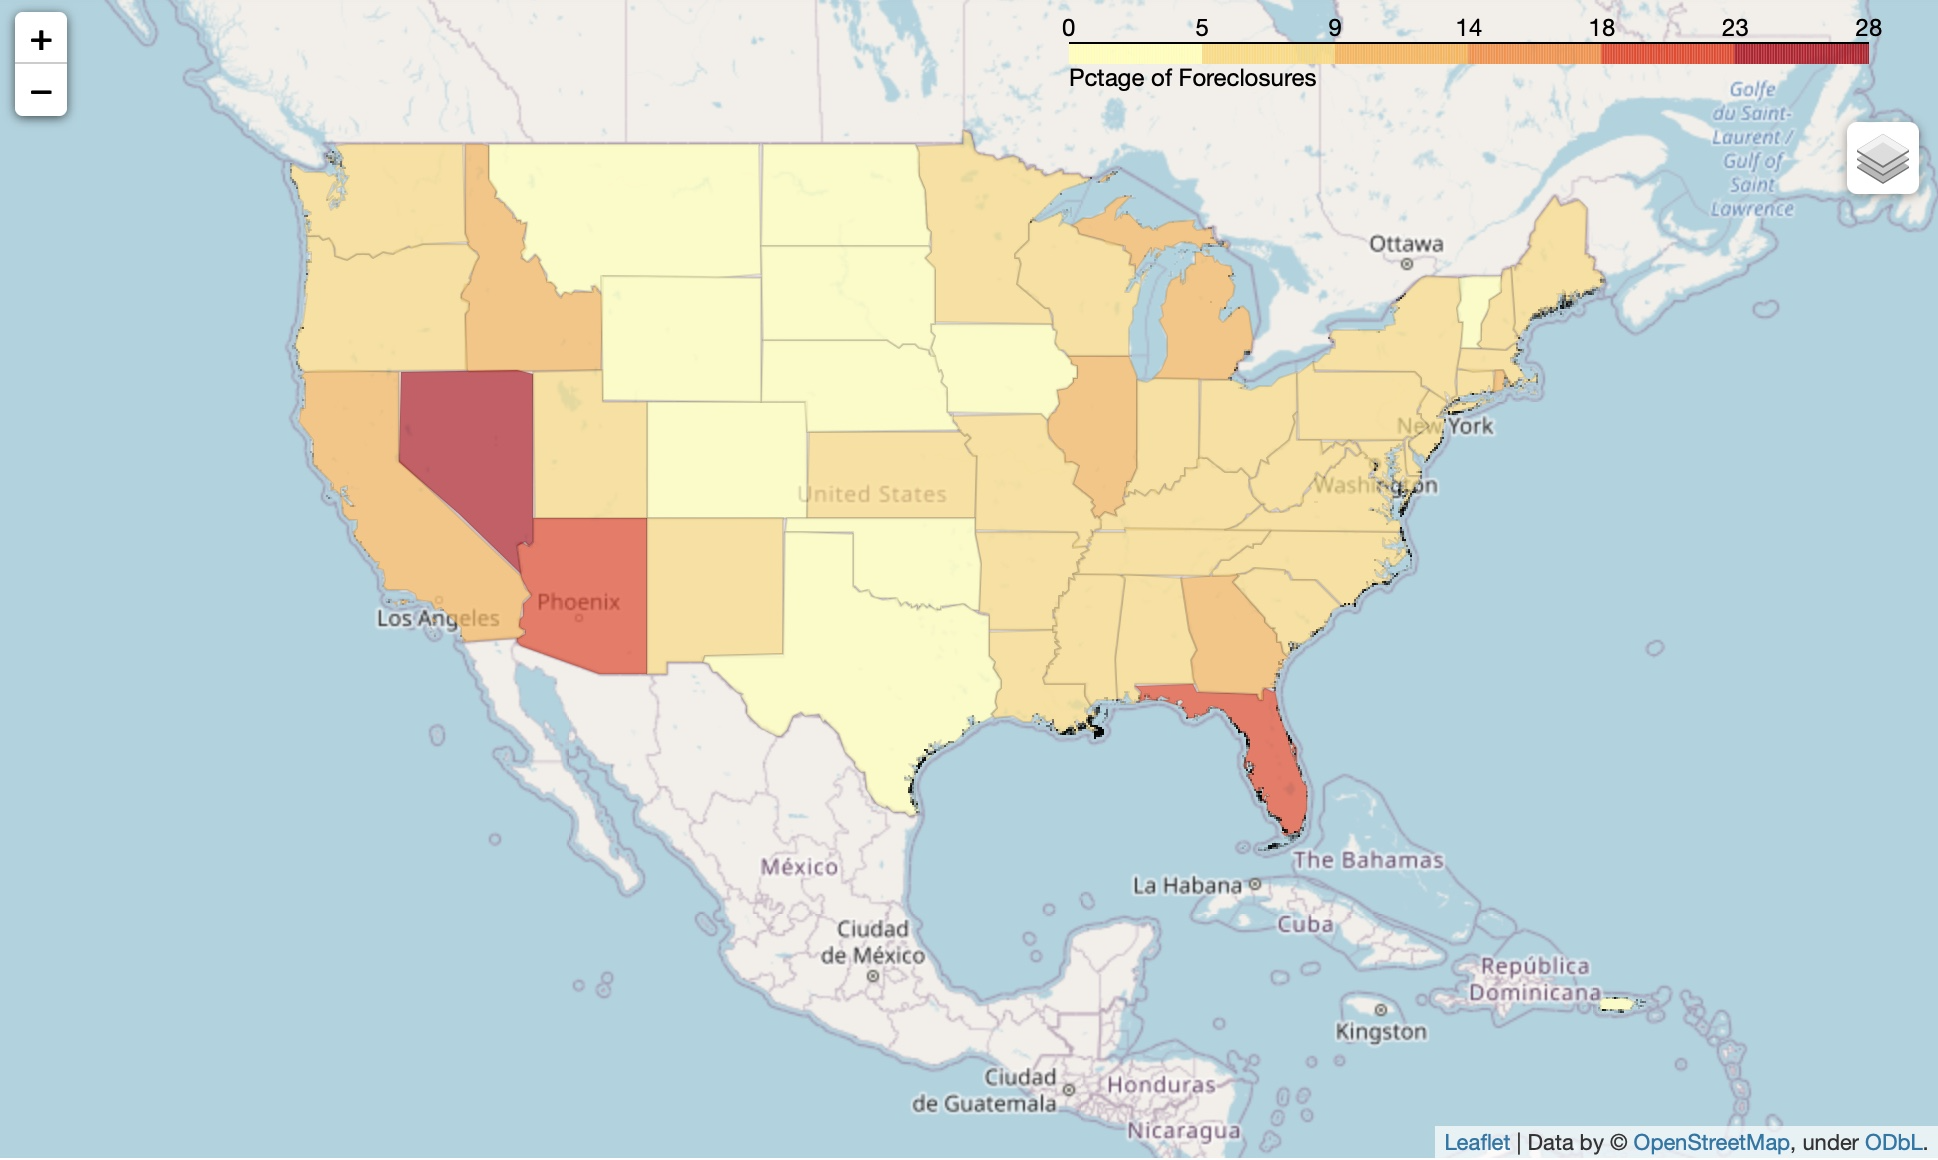

In [7]:
## Uncomment Code Below to generate the Folium Maps to display Foreclosures by State. I generated the Maps 
## and saved a PNG file of the Chart and is displaed Below

#fannie_foreclosed_pct_map = folium.Map(location=[35, -95],zoom_start=4.25)
#folium.Choropleth(
#    geo_data=state_geodata,
#    name="choropleth",
#    data=df_data_plot,
#    columns=["state", "ForeclosedPctage"],
#     key_on="feature.properties.STATE_ABBR",
#  
#    fill_color="YlOrRd",
#    fill_opacity=0.7,
#    line_opacity=.1,
#    legend_name=" Pctage of Foreclosures",
#).add_to(fannie_foreclosed_pct_map)

#folium.LayerControl().add_to(fannie_foreclosed_pct_map)
#fannie_foreclosed_pct_map


Image(filename='PctageOfForeclosures.png')

## Visualizing ForeClosures vs Debt to Income Ratios,  Loan To Values and Credit Scores

In [8]:
df_delinq = df_fnma_data[['LOAN_ID','state','dti','oltv','CSCORE_MN','LAST_UPB',
                          'F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE','FCC_DTE']].copy()

### Binning OLTV and DTI values

bins = [0, 20, 40, 60, 80,100] 
df_delinq['binned_oltv'] = pd.cut(df_delinq['oltv'],bins)
df_delinq['binned_dti'] = pd.cut(df_delinq['dti'],bins)


### Binning Minimum Credit Scores into Buckets

list_fico_buckets = [0,580,670,740,800,1000]
df_delinq['binned_CSCORE_MN'] = pd.cut(df_delinq['CSCORE_MN'],list_fico_buckets)


df_delinq.loc[(df_delinq['F60_DTE'].isna()==True) &
              (df_delinq['F90_DTE'].isna()==True) &
              (df_delinq['F120_DTE'].isna()==True) &
              (df_delinq['F180_DTE'].isna()==True) &
              (df_delinq['FCC_DTE'].isna()==True) 
              ,'NO_DEFAULT'] = 1

df_delinq_grouped_oltv = df_delinq[['F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE',
                                    'FCC_DTE','NO_DEFAULT','binned_oltv']].groupby('binned_oltv').count()

df_delinq_grouped_dti = df_delinq[['F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE',
                                    'FCC_DTE','NO_DEFAULT','binned_dti']].groupby('binned_dti').count()


df_delinq_grouped_cscore = df_delinq[['F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE',
                                    'FCC_DTE','NO_DEFAULT','binned_CSCORE_MN']].groupby('binned_CSCORE_MN').count()

df_delinq_grouped_oltv['TOTAL'] = df_delinq_grouped_oltv['F60_DTE']+df_delinq_grouped_oltv['F90_DTE']+\
                                df_delinq_grouped_oltv['F120_DTE']+df_delinq_grouped_oltv['F180_DTE']+\
                                df_delinq_grouped_oltv['FCC_DTE']+df_delinq_grouped_oltv['NO_DEFAULT']
        
        
df_delinq_grouped_dti['TOTAL'] = df_delinq_grouped_dti['F60_DTE']+df_delinq_grouped_dti['F90_DTE']+\
                                df_delinq_grouped_dti['F120_DTE']+df_delinq_grouped_dti['F180_DTE']+\
                                df_delinq_grouped_dti['FCC_DTE']+df_delinq_grouped_dti['NO_DEFAULT']


df_delinq_grouped_cscore['TOTAL'] = df_delinq_grouped_cscore['F60_DTE']+df_delinq_grouped_cscore['F90_DTE']+\
                                df_delinq_grouped_cscore['F120_DTE']+df_delinq_grouped_cscore['F180_DTE']+\
                                df_delinq_grouped_cscore['FCC_DTE']+df_delinq_grouped_cscore['NO_DEFAULT']





#### Calculating percentage delinquencies/foreclosures in each OLTV and DTI bin

df_delinqpct_grouped_oltv = df_delinq_grouped_oltv.copy()
df_delinqpct_grouped_dti = df_delinq_grouped_dti.copy()
df_delinqpct_grouped_cscore = df_delinq_grouped_cscore.copy()


for col in ['F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE','FCC_DTE','NO_DEFAULT']:
    
    df_delinqpct_grouped_oltv[col] = df_delinq_grouped_oltv[col]/df_delinq_grouped_oltv['TOTAL']*100
    df_delinqpct_grouped_dti[col] = df_delinq_grouped_dti[col]/df_delinq_grouped_dti['TOTAL']*100
    df_delinqpct_grouped_cscore[col] = df_delinq_grouped_cscore[col]/df_delinq_grouped_cscore['TOTAL']*100



### Count of Delinquencies and Foreclosures as a function of Original LTV or DTI

The charts below are histograms of delinquencies and foreclosures for each OLTV/DTI bucket. While the general trend is increasing, it is not obvious

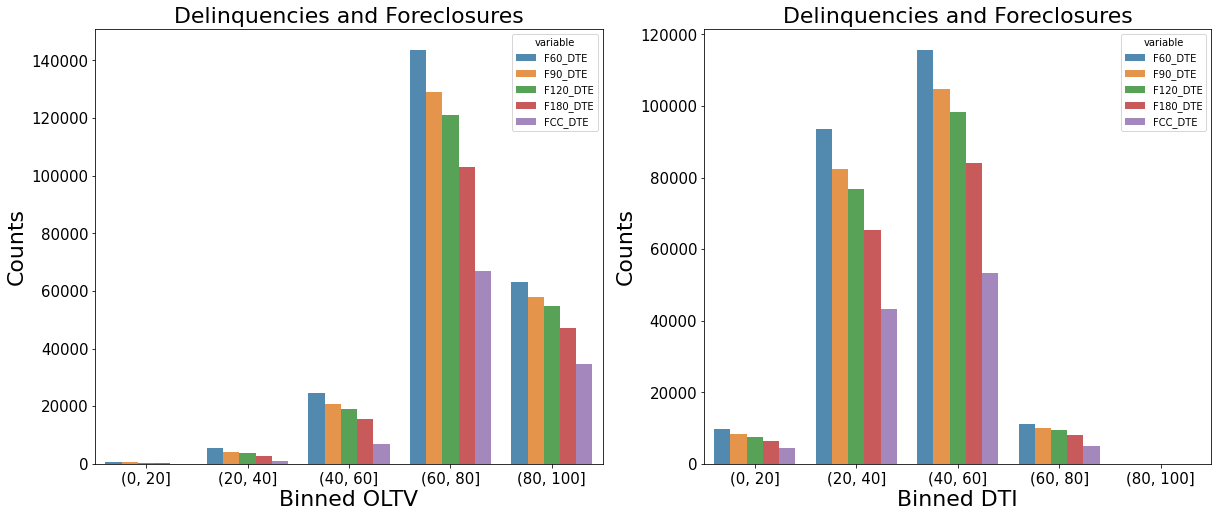

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

data = df_delinq_grouped_oltv.drop(['NO_DEFAULT','TOTAL'], axis = 1).reset_index().melt(id_vars='binned_oltv')
plt.subplot(1,2,1)
barplt = sns.barplot(x=data['binned_oltv'], y=data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned OLTV', fontsize = 22)
barplt.set_ylabel('Counts', fontsize = 22)
barplt.set_title('Delinquencies and Foreclosures', fontsize = 22)
barplt.tick_params(labelsize = 15)


data = df_delinq_grouped_dti.drop(['NO_DEFAULT','TOTAL'], axis = 1).reset_index().melt(id_vars='binned_dti')
plt.subplot(1,2,2)
barplt = sns.barplot(x=data['binned_dti'], y=data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned DTI', fontsize = 22)
barplt.set_ylabel('Counts', fontsize = 22)
barplt.set_title('Delinquencies and Foreclosures', fontsize = 22)
barplt.tick_params(labelsize = 15)


### Histogram of Delinquencies or Foreclosures as a Percentage of Total Loans issued in each OLTV/DTI bucket.

In this histogram below it is much more obvious that that Delinquencies and Foreclosures increase with increasing LTV and DTI ratios

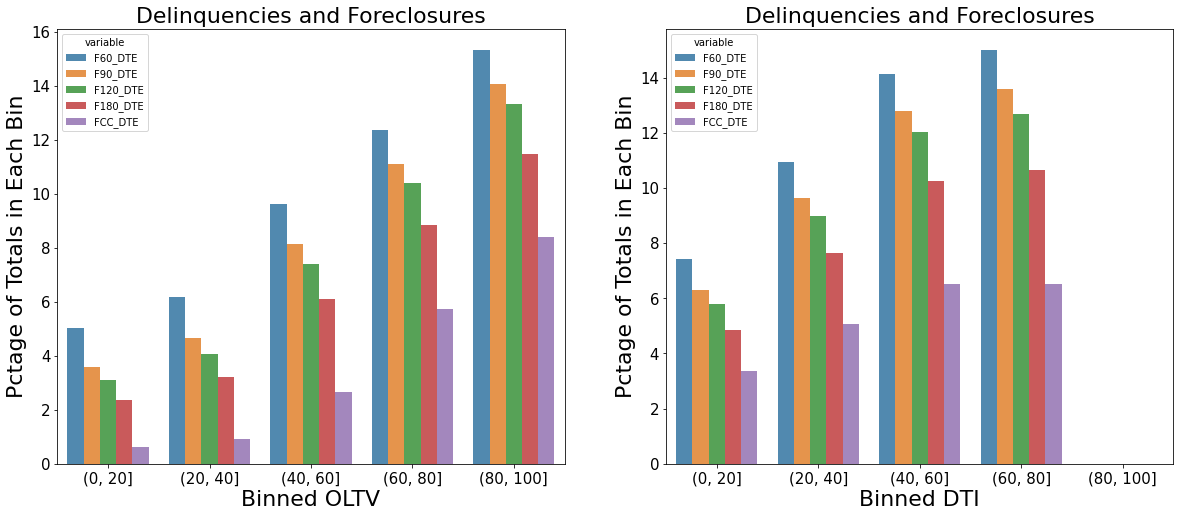

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

data = df_delinqpct_grouped_oltv.drop(['NO_DEFAULT','TOTAL'], axis = 1).reset_index().melt(id_vars='binned_oltv')
plt.subplot(1,2,1)
barplt = sns.barplot(x=data['binned_oltv'], y=data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned OLTV', fontsize = 22)
barplt.set_ylabel('Pctage of Totals in Each Bin', fontsize = 22)
barplt.set_title('Delinquencies and Foreclosures', fontsize = 22)
barplt.tick_params(labelsize = 15)


data = df_delinqpct_grouped_dti.drop(['NO_DEFAULT','TOTAL'], axis = 1).reset_index().melt(id_vars='binned_dti')
plt.subplot(1,2,2)
barplt = sns.barplot(x=data['binned_dti'], y=data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned DTI', fontsize = 22)
barplt.set_ylabel('Pctage of Totals in Each Bin', fontsize = 22)
barplt.set_title('Delinquencies and Foreclosures', fontsize = 22)
barplt.tick_params(labelsize = 15)

### The plots below are histograms of all delinquencies (60, 90, 120, 180 day) and foreclosures within each OLTV/DTI bucket as a percentage of total loans issued in each bucket.

One can again see that delinquencies are increasing functions of DTI and LTV

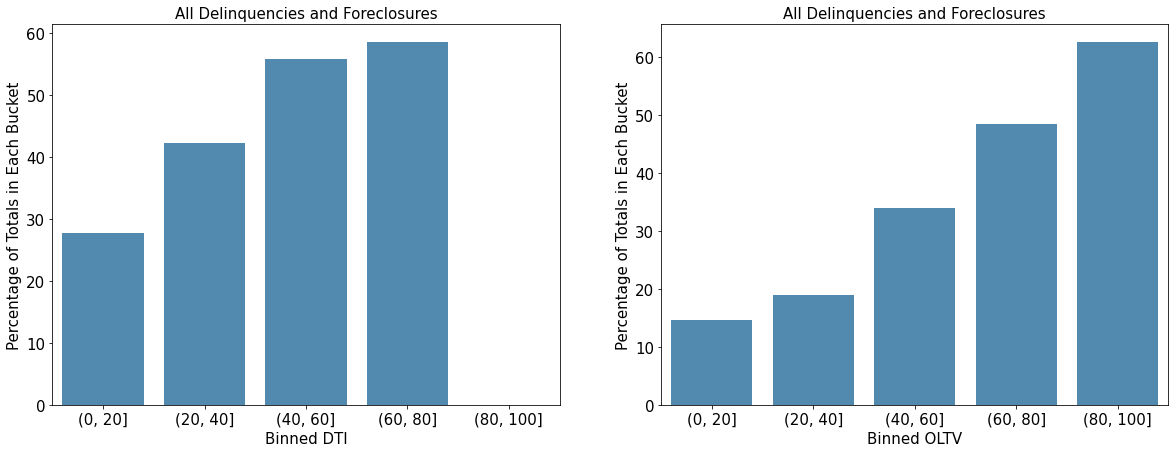

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,7))

data = df_delinqpct_grouped_dti['NO_DEFAULT'].reset_index().melt(id_vars='binned_dti')

plt.subplot(1,2,1)
barplt = sns.barplot(x=data['binned_dti'], y=100-data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned DTI', fontsize = 15)
barplt.set_ylabel('Percentage of Totals in Each Bucket', fontsize = 15)
barplt.set_title('All Delinquencies and Foreclosures', fontsize = 15)
barplt.tick_params(labelsize = 15)
ax1.get_legend().remove()

plt.subplot(1,2,2)
data = df_delinqpct_grouped_oltv['NO_DEFAULT'].reset_index().melt(id_vars='binned_oltv')
barplt = sns.barplot(x=data['binned_oltv'], y=100-data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned OLTV', fontsize = 15)
barplt.set_ylabel('Percentage of Totals in Each Bucket', fontsize = 15)
barplt.set_title('All Delinquencies and Foreclosures', fontsize = 15)
barplt.tick_params(labelsize = 15)
ax2.get_legend().remove()


### The plots below are histograms of delinquencies and foreclosures within each credit score bucket as a total count as well percentage of total loans issued in each bucket.

As one would expect, delinquencies decrease with increasing credits scores

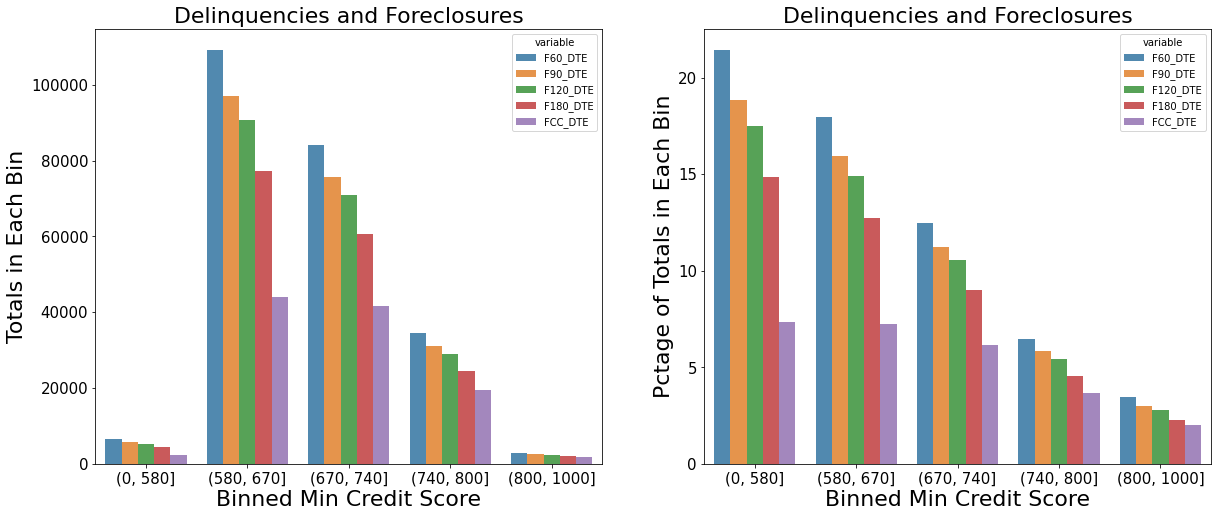

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

data = df_delinq_grouped_cscore.drop(['NO_DEFAULT','TOTAL'], axis = 1).reset_index().melt(id_vars='binned_CSCORE_MN')
plt.subplot(1,2,1)
barplt = sns.barplot(x=data['binned_CSCORE_MN'], y=data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned Min Credit Score', fontsize = 22)
barplt.set_ylabel('Totals in Each Bin', fontsize = 22)
barplt.set_title('Delinquencies and Foreclosures', fontsize = 22)
barplt.tick_params(labelsize = 15)


data = df_delinqpct_grouped_cscore.drop(['NO_DEFAULT','TOTAL'], axis = 1).reset_index().melt(id_vars='binned_CSCORE_MN')
plt.subplot(1,2,2)
barplt = sns.barplot(x=data['binned_CSCORE_MN'], y=data['value'],hue=data['variable'],alpha=0.85,linewidth=2)
barplt.set_xlabel('Binned Min Credit Score', fontsize = 22)
barplt.set_ylabel('Pctage of Totals in Each Bin', fontsize = 22)
barplt.set_title('Delinquencies and Foreclosures', fontsize = 22)
barplt.tick_params(labelsize = 15)

### Defaults as a function of some categorical variables, Original Channel, Occupancy Status, First Time Home Buyer Flag (FTHB) and Purpose.

At a glance, loans which were used to buy second or third homes (FTHB_Flag = N) or for a Cash Out Refi (purpose = C) seem to default at higher rates

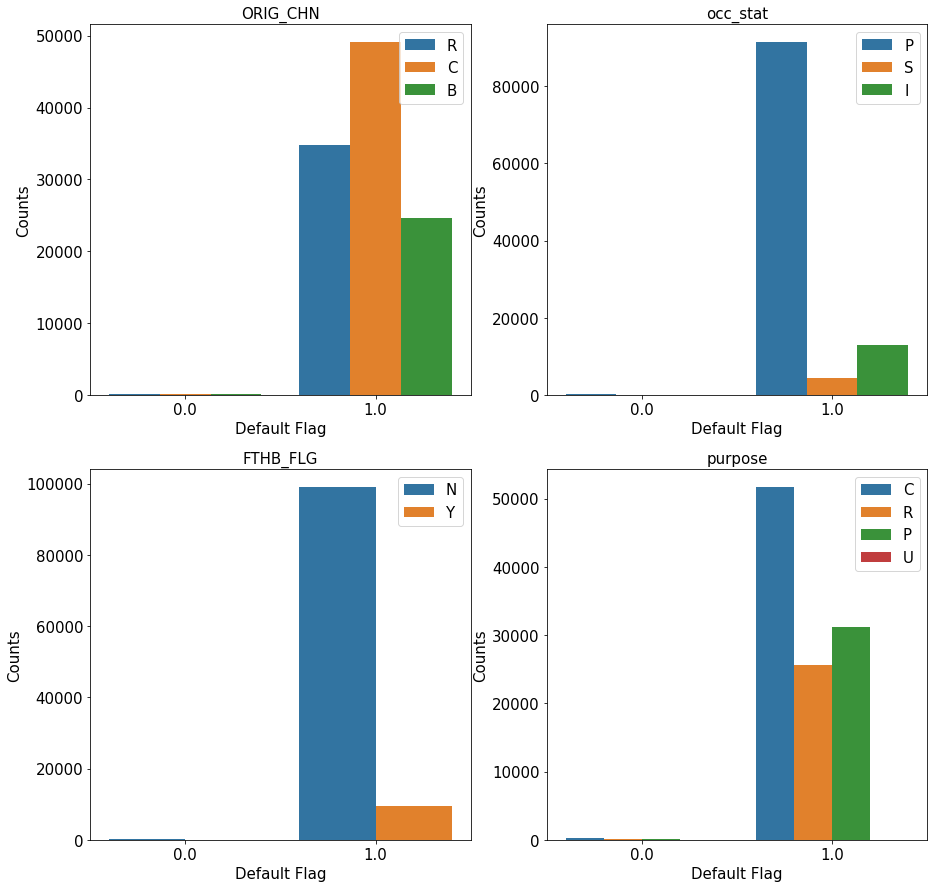

In [13]:
cols = ['ORIG_CHN','occ_stat','FTHB_FLG','purpose']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

for i, col in zip(range(1,5), cols):
    plt.subplot(2,2,i)
    countplt=sns.countplot(x="COMPLT_FLG", hue=col, data=df_fnma_data)
    countplt.set_xlabel('Default Flag', fontsize = 15)
    countplt.set_ylabel('Counts', fontsize = 15)
    countplt.set_title(col,fontsize = 15)
    countplt.tick_params(labelsize = 15)
    plt.legend(loc="upper right", prop={'size': 15})

In [14]:
del df_fnma_data
del df_fnma_dataQ1
del df_fnma_dataQ2
del df_fnma_dataQ3
del df_fnma_dataQ4